__Analysing the StudentLife study__<br>
Eva Aßmann and Paul Vogler

# Imports

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import glob
import ntpath
import pandas as pd
import numpy as np
import matplotlib as plt
from fbprophet import Prophet
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Providing credentials
from google.colab import auth
auth.authenticate_user()
print('Authenticated') 

Authenticated


**SET THE BASEPATH TO THE LINKED DRIVE AND GCLOUD ENVIRONMENT!!**<br>
there need to be subfolders: Stress, Sleep, conversation, activity containing the files from the respective EMA subfolders (capital) and from the sensing subfolder (lower case)

In [0]:
basepath = "/content/drive/My Drive/Master/Introduction_ProfileAreas/"
my_env_str = 'PROJECTID'

In [6]:
%env GCLOUD_PROJECT=PROJECTID

env: GCLOUD_PROJECT=boxwood-bee-258411


In [0]:
%load_ext google.colab.data_table

## Using BigQuery Helper: https://github.com/SohierDane/BigQuery_Helper/blob/master/bq_helper.py


In [0]:
import pandas as pd

"""
Helper class to simplify common read-only BigQuery tasks.
"""


import pandas as pd
import time

from google.cloud import bigquery


class BigQueryHelper(object):
    """
    Helper class to simplify common BigQuery tasks like executing queries,
    showing table schemas, etc without worrying about table or dataset pointers.

    See the BigQuery docs for details of the steps this class lets you skip:
    https://googlecloudplatform.github.io/google-cloud-python/latest/bigquery/reference.html
    """

    def __init__(self, active_project, dataset_name, max_wait_seconds=180):
        self.project_name = active_project
        self.dataset_name = dataset_name
        self.max_wait_seconds = max_wait_seconds
        self.client = bigquery.Client()
        self.__dataset_ref = self.client.dataset(self.dataset_name, project=self.project_name)
        self.dataset = None
        self.tables = dict()  # {table name (str): table object}
        self.__table_refs = dict()  # {table name (str): table reference}
        self.total_gb_used_net_cache = 0
        self.BYTES_PER_GB = 2**30

    def __fetch_dataset(self):
        """
        Lazy loading of dataset. For example,
        if the user only calls `self.query_to_pandas` then the
        dataset never has to be fetched.
        """
        if self.dataset is None:
            self.dataset = self.client.get_dataset(self.__dataset_ref)

    def __fetch_table(self, table_name):
        """
        Lazy loading of table
        """
        self.__fetch_dataset()
        if table_name not in self.__table_refs:
            self.__table_refs[table_name] = self.dataset.table(table_name)
        if table_name not in self.tables:
            self.tables[table_name] = self.client.get_table(self.__table_refs[table_name])

    def __handle_record_field(self, row, schema_details, top_level_name=''):
        """
        Unpack a single row, including any nested fields.
        """
        name = row['name']
        if top_level_name != '':
            name = top_level_name + '.' + name
        schema_details.append([{
            'name': name,
            'type': row['type'],
            'mode': row['mode'],
            'fields': pd.np.nan,
            'description': row['description']
                               }])
        # float check is to dodge row['fields'] == np.nan
        if type(row.get('fields', 0.0)) == float:
            return None
        for entry in row['fields']:
            self.__handle_record_field(entry, schema_details, name)

    def __unpack_all_schema_fields(self, schema):
        """
        Unrolls nested schemas. Returns dataframe with one row per field,
        and the field names in the format accepted by the API.
        Results will look similar to the website schema, such as:
            https://bigquery.cloud.google.com/table/bigquery-public-data:github_repos.commits?pli=1

        Args:
            schema: DataFrame derived from api repr of raw table.schema
        Returns:
            Dataframe of the unrolled schema.
        """
        schema_details = []
        schema.apply(lambda row:
            self.__handle_record_field(row, schema_details), axis=1)
        result = pd.concat([pd.DataFrame.from_dict(x) for x in schema_details])
        result.reset_index(drop=True, inplace=True)
        del result['fields']
        return result

    def table_schema(self, table_name):
        """
        Get the schema for a specific table from a dataset.
        Unrolls nested field names into the format that can be copied
        directly into queries. For example, for the `github.commits` table,
        the this will return `committer.name`.

        This is a very different return signature than BigQuery's table.schema.
        """
        self.__fetch_table(table_name)
        raw_schema = self.tables[table_name].schema
        schema = pd.DataFrame.from_dict([x.to_api_repr() for x in raw_schema])
        # the api_repr only has the fields column for tables with nested data
        if 'fields' in schema.columns:
            schema = self.__unpack_all_schema_fields(schema)
        # Set the column order
        schema = schema[['name', 'type', 'mode', 'description']]
        return schema

    def list_tables(self):
        """
        List the names of the tables in a dataset
        """
        self.__fetch_dataset()
        return([x.table_id for x in self.client.list_tables(self.dataset)])

    def estimate_query_size(self, query):
        """
        Estimate gigabytes scanned by query.
        Does not consider if there is a cached query table.
        See https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs#configuration.dryRun
        """
        my_job_config = bigquery.job.QueryJobConfig()
        my_job_config.dry_run = True
        my_job = self.client.query(query, job_config=my_job_config)
        return my_job.total_bytes_processed / self.BYTES_PER_GB

    def query_to_pandas(self, query):
        """
        Execute a SQL query & return a pandas dataframe
        """
        my_job = self.client.query(query)
        start_time = time.time()
        while not my_job.done():
            if (time.time() - start_time) > self.max_wait_seconds:
                print("Max wait time elapsed, query cancelled.")
                self.client.cancel_job(my_job.job_id)
                return None
            time.sleep(0.1)
        # Queries that hit errors will return an exception type.
        # Those exceptions don't get raised until we call my_job.to_dataframe()
        # In that case, my_job.total_bytes_billed can be called but is None
        if my_job.total_bytes_billed:
            self.total_gb_used_net_cache += my_job.total_bytes_billed / self.BYTES_PER_GB
        return my_job.to_dataframe()

    def query_to_pandas_safe(self, query, max_gb_scanned=1):
        """
        Execute a query, but only if the query would scan less than `max_gb_scanned` of data.
        """
        query_size = self.estimate_query_size(query)
        if query_size <= max_gb_scanned:
            return self.query_to_pandas(query)
        msg = "Query cancelled; estimated size of {0} exceeds limit of {1} GB"
        print(msg.format(query_size, max_gb_scanned))

    def head(self, table_name, num_rows=5, start_index=None, selected_columns=None):
        """
        Get the first n rows of a table as a DataFrame.
        Does not perform a full table scan; should use a trivial amount of data as long as n is small.
        """
        self.__fetch_table(table_name)
        active_table = self.tables[table_name]
        schema_subset = None
        if selected_columns:
            schema_subset = [col for col in active_table.schema if col.name in selected_columns]
        results = self.client.list_rows(active_table, selected_fields=schema_subset,
            max_results=num_rows, start_index=start_index)
        results = [x for x in results]
        return pd.DataFrame(
            data=[list(x.values()) for x in results], columns=list(results[0].keys()))

# Is stress correlated to the activity level?

## Explore stress and activity data

In [9]:
stress = BigQueryHelper(my_env_str,'StudentLife_Stress')
df10 = pd.io.gbq.read_gbq('''
  SELECT resp_time, location, level 
  FROM `PROJECTID.StudentLife_Stress.Stress_u10`
''', project_id='PROJECTID', dialect='standard')
df16 = pd.io.gbq.read_gbq('''
  SELECT resp_time, location, level 
  FROM `PROJECTID.StudentLife_Stress.Stress_u10`
''', project_id='PROJECTID', dialect='standard')

activity = BigQueryHelper(my_env_str, 'StudentLife_Activity')
DF10 = pd.io.gbq.read_gbq('''
  SELECT timestamp, _activity_inference
  FROM `PROJECTID.StudentLife_Activity.activity_u10`
''', project_id='PROJECTID', dialect='standard')
DF16 = pd.io.gbq.read_gbq('''
  SELECT timestamp, _activity_inference
  FROM `PROJECTID.StudentLife_Activity.activity_u16`
''', project_id='PROJECTID', dialect='standard')

INFO:pandas_gbq.gbq:Total time taken 25.66 s.
Finished at 2019-12-12 18:50:44.
INFO:pandas_gbq.gbq:Total time taken 23.64 s.
Finished at 2019-12-12 18:51:07.


### Stress response

In [10]:
stress.list_tables()

['Stress_u10', 'Stress_u16']

In [11]:
stress.table_schema('Stress_u10')

,name,type,mode,description
0,null,STRING,NULLABLE,None
1,resp_time,INTEGER,NULLABLE,None
2,location,STRING,NULLABLE,None
3,level,INTEGER,NULLABLE,None


In [12]:
stress.head('Stress_u10', 5)

,null,resp_time,location,level
0,None,1364800742,"43.70241112,-72.28788985",1
1,None,1364770637,"43.70243257,-72.28772434",1
2,None,1364928993,"43.70679334,-72.28767766",1
3,None,1364609271,"43.70644884,-72.28820168",1
4,None,1364609265,"43.70647211,-72.28802604",1


In [13]:
stress.table_schema('Stress_u16')

,name,type,mode,description
0,null,STRING,NULLABLE,None
1,resp_time,INTEGER,NULLABLE,None
2,location,STRING,NULLABLE,None
3,level,INTEGER,NULLABLE,None


In [14]:
stress.head('Stress_u16', 5)

,null,resp_time,location,level
0,2,1364121767,None,None
1,"43.70523672,-72.28864567",1364121769,None,None
2,"43.70523672,-72.28864567",1364121771,None,None
3,4,1364121765,None,None
4,1,1364121766,None,None


In [15]:
df10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 3 columns):
resp_time    112 non-null int64
location     106 non-null object
level        106 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.8+ KB


In [16]:
for elem in df10.columns:
  print(elem)
  print(df10[elem].unique())

resp_time
[1364800742 1364770637 1364928993 1364609271 1364609265 1364617699
 1364687545 1364747489 1364787310 1364947306 1365101407 1365062511
 1365097718 1365125458 1365149095 1365179756 1365299962 1365321912
 1365387463 1365991655 1365533888 1365546713 1365524784 1365706531
 1365722540 1365632224 1365667982 1365804637 1365896515 1366100076
 1366216231 1366258536 1366993868 1366434862 1366915838 1366789695
 1367286252 1366689779 1366739814 1366703855 1366735713 1366852996
 1367179319 1367474824 1367558468 1367956857 1368030863 1368073765
 1368589234 1368821852 1364609268 1364428862 1365120705 1365207346
 1365652667 1366057780 1366163551 1366175910 1366999326 1366734466
 1368908148 1367208278 1364869924 1364609269 1364702853 1364699474
 1364680918 1364752051 1364968520 1364806252 1364833955 1364968519
 1365040681 1365213650 1365234458 1365266723 1365357079 1365400248
 1365438631 1365473663 1365482894 1365561812 1365656970 1365738620
 1366302399 1366507435 1366431434 1366595714 1366562

In [17]:
df10[df10.location.isnull()]

,resp_time,location,level
106,1364119459,None,NaN
107,1364121099,None,NaN
108,1364118564,None,NaN
109,1364120899,None,NaN
110,1364120399,None,NaN
111,1364121776,None,NaN


In [18]:
df16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 3 columns):
resp_time    112 non-null int64
location     106 non-null object
level        106 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.8+ KB


In [19]:
df16.describe()

,resp_time,level
count,1.120000e+02,106.000000
mean,1.365917e+09,2.396226
std,1.189338e+06,1.465016
min,1.364119e+09,1.000000
25%,1.364970e+09,1.000000
50%,1.365642e+09,2.000000
75%,1.366712e+09,4.000000
max,1.369328e+09,5.000000


In [20]:
df16[df16.location.isnull()]

,resp_time,location,level
106,1364119459,None,NaN
107,1364121099,None,NaN
108,1364118564,None,NaN
109,1364120899,None,NaN
110,1364120399,None,NaN
111,1364121776,None,NaN


In [0]:
df_stress = pd.merge(df10, df16, on=['resp_time','level','location'], how='inner')

In [22]:
df_stress.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112 entries, 0 to 111
Data columns (total 3 columns):
resp_time    112 non-null int64
location     106 non-null object
level        106 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.5+ KB


In [23]:
df_stress[df_stress.location.isnull()]

,resp_time,location,level
106,1364119459,None,NaN
107,1364121099,None,NaN
108,1364118564,None,NaN
109,1364120899,None,NaN
110,1364120399,None,NaN
111,1364121776,None,NaN


Missing location and stress level response for the same six unix time stamps in both tables.

### Activity inference


In [24]:
activity.list_tables()

['activity_u10', 'activity_u16']

In [25]:
activity.table_schema('activity_u10')

,name,type,mode,description
0,timestamp,INTEGER,NULLABLE,None
1,_activity_inference,INTEGER,NULLABLE,None


In [26]:
activity.head('activity_u10', 5)

,timestamp,_activity_inference
0,1364392643,2
1,1364392645,2
2,1364406090,2
3,1364410633,2
4,1364410636,2


In [27]:
activity.table_schema('activity_u16')

,name,type,mode,description
0,timestamp,INTEGER,NULLABLE,None
1,_activity_inference,INTEGER,NULLABLE,None


In [28]:
activity.head('activity_u16', 5)

,timestamp,_activity_inference
0,None,None
1,None,None
2,None,None
3,None,None
4,None,None


In [29]:
DF10.shape, DF16.shape

((1062318, 2), (981498, 2))

In [30]:
DF10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1062318 entries, 0 to 1062317
Data columns (total 2 columns):
timestamp              531159 non-null float64
_activity_inference    531159 non-null float64
dtypes: float64(2)
memory usage: 16.2 MB


In [31]:
DF10[DF10.timestamp.isnull()]

,timestamp,_activity_inference
4553,NaN,NaN
4554,NaN,NaN
4555,NaN,NaN
4556,NaN,NaN
4557,NaN,NaN
...,...,...
535707,NaN,NaN
535708,NaN,NaN
535709,NaN,NaN
535710,NaN,NaN


In [32]:
DF16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981498 entries, 0 to 981497
Data columns (total 2 columns):
timestamp              490749 non-null float64
_activity_inference    490749 non-null float64
dtypes: float64(2)
memory usage: 15.0 MB


In [33]:
DF16[DF16.timestamp.isnull()]

,timestamp,_activity_inference
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
490744,NaN,NaN
490745,NaN,NaN
490746,NaN,NaN
490747,NaN,NaN


## Preprocess data
1. Impute missing days
2. Get daily averages

### Stress response

1. Change unix timestamp into datetime
2. Impute missing values for the first study day with the next known day

__Individuals__

In [34]:
df10.resp_time = pd.to_datetime(df10.resp_time, unit='s')
df10.sort_values(by='resp_time')

,resp_time,location,level
108,2013-03-24 09:49:24,None,NaN
106,2013-03-24 10:04:19,None,NaN
110,2013-03-24 10:19:59,None,NaN
109,2013-03-24 10:28:19,None,NaN
107,2013-03-24 10:31:39,None,NaN
...,...,...,...
100,2013-05-15 21:16:06,"43.70324666,-72.29028792",4.0
101,2013-05-15 21:17:00,"43.70324666,-72.29028792",4.0
49,2013-05-17 20:17:32,"43.70620585,-72.28792804",1.0
60,2013-05-18 20:15:48,"43.70290198,-72.28795273",2.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4238: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


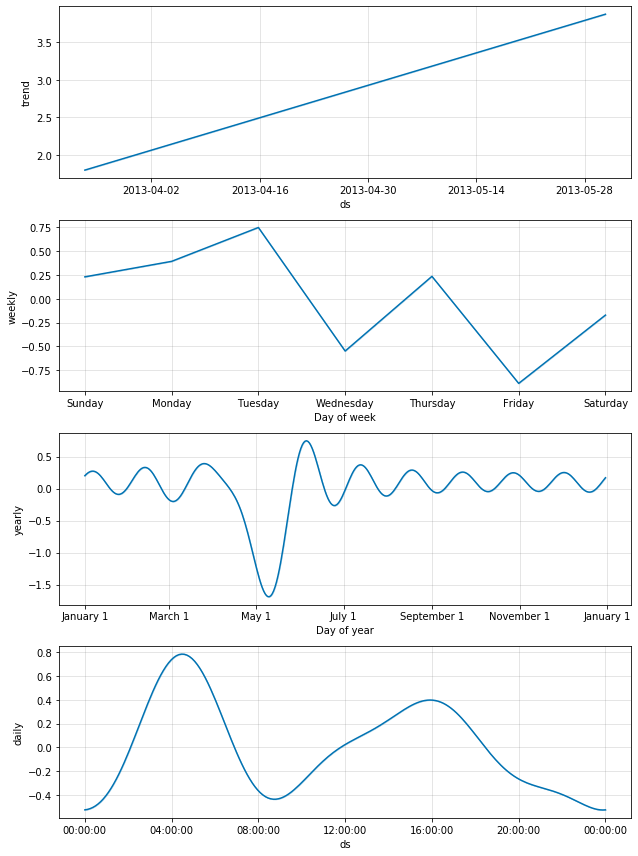

In [35]:
# Impute
df10.location[df10.location.isnull()] = df10.location.iloc[51]
df10.level[df10.level.isnull()] = df10.level.iloc[51]
# Time Series Analysis
prophet10 = df10[['resp_time','level']] 
prophet10.rename(columns={'resp_time':'ds','level':'y'}, inplace=True)
m10 = Prophet(yearly_seasonality=True)
m10.fit(prophet10)
future10 = m10.make_future_dataframe(periods=7)
forecast10 = m10.predict(future10)
fig = m10.plot_components(forecast10)

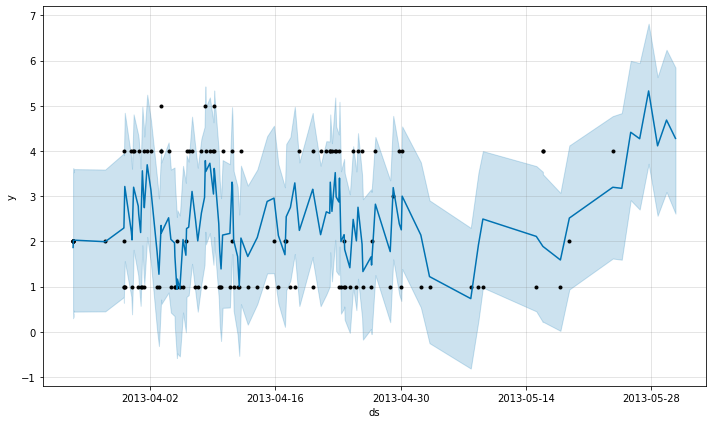

In [36]:
fig1 = m10.plot(forecast10)

In [37]:
df16.resp_time = pd.to_datetime(df16.resp_time, unit='s')
df16.sort_values(by='resp_time')

,resp_time,location,level
108,2013-03-24 09:49:24,None,NaN
106,2013-03-24 10:04:19,None,NaN
110,2013-03-24 10:19:59,None,NaN
109,2013-03-24 10:28:19,None,NaN
107,2013-03-24 10:31:39,None,NaN
...,...,...,...
100,2013-05-15 21:16:06,"43.70324666,-72.29028792",4.0
101,2013-05-15 21:17:00,"43.70324666,-72.29028792",4.0
49,2013-05-17 20:17:32,"43.70620585,-72.28792804",1.0
60,2013-05-18 20:15:48,"43.70290198,-72.28795273",2.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4238: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



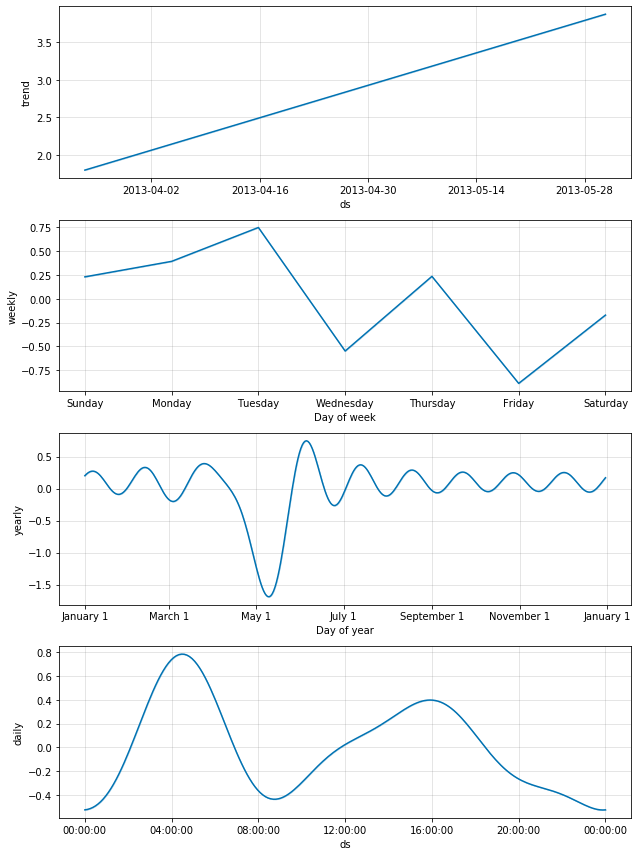

In [38]:
# Impute
df16.location[df16.location.isnull()] = df16.location.iloc[51]
df16.level[df16.level.isnull()] = df16.level.iloc[51]
# Time Series Analysis
prophet16 = df16[['resp_time','level']] 
prophet16.rename(columns={'resp_time':'ds','level':'y'}, inplace=True)
m16 = Prophet(yearly_seasonality=True)
m16.fit(prophet16)
future16 = m10.make_future_dataframe(periods=7)
forecast16 = m10.predict(future16)
fig = m16.plot_components(forecast16)

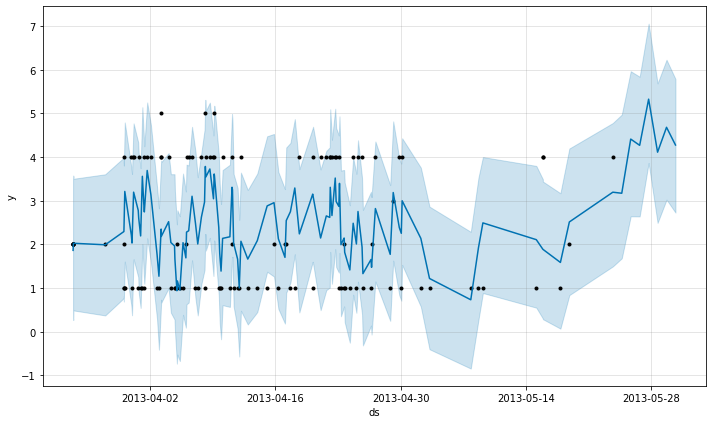

In [39]:
fig1 = m16.plot(forecast16)

__Overall__

In [0]:
df_stress.resp_time = pd.to_datetime(df_stress.resp_time, unit='s')

In [41]:
df_stress[df_stress.location.isnull()]

,resp_time,location,level
106,2013-03-24 10:04:19,None,NaN
107,2013-03-24 10:31:39,None,NaN
108,2013-03-24 09:49:24,None,NaN
109,2013-03-24 10:28:19,None,NaN
110,2013-03-24 10:19:59,None,NaN
111,2013-03-24 10:42:56,None,NaN


In [42]:
df_stress.sort_values(by='resp_time')

,resp_time,location,level
108,2013-03-24 09:49:24,None,NaN
106,2013-03-24 10:04:19,None,NaN
110,2013-03-24 10:19:59,None,NaN
109,2013-03-24 10:28:19,None,NaN
107,2013-03-24 10:31:39,None,NaN
...,...,...,...
100,2013-05-15 21:16:06,"43.70324666,-72.29028792",4.0
101,2013-05-15 21:17:00,"43.70324666,-72.29028792",4.0
49,2013-05-17 20:17:32,"43.70620585,-72.28792804",1.0
60,2013-05-18 20:15:48,"43.70290198,-72.28795273",2.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4238: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



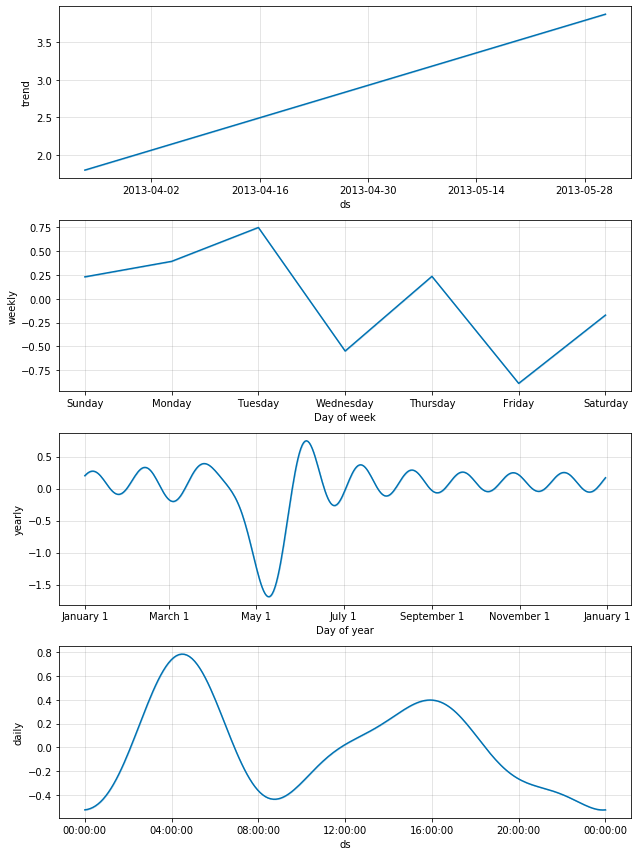

In [43]:
#Impute
df_stress.location[df_stress.location.isnull()] = df_stress.location.iloc[51]
df_stress.level[df_stress.level.isnull()] = df_stress.level.iloc[51]
#Time Series Analysis
prophet_stress = df_stress[['resp_time','level']] 
prophet_stress.rename(columns={'resp_time':'ds','level':'y'}, inplace=True)
m = Prophet(yearly_seasonality=True)
m.fit(prophet_stress)
future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)
fig2 = m.plot_components(forecast)

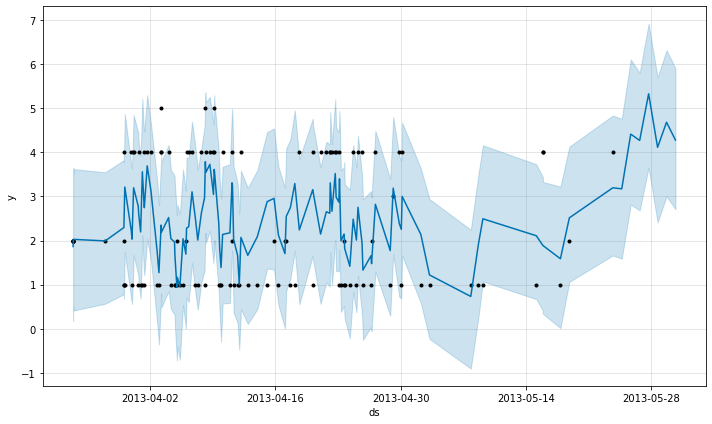

In [44]:
fig1 = m.plot(forecast)

### Activity inference

__Individuals__

In [0]:
DF10.timestamp = pd.to_datetime(DF10.timestamp, unit='s')
sortdf = DF10.sort_values(by='timestamp')

In [46]:
1062318-531159

531159

In [0]:
head = sortdf.head(531159)
tail = sortdf.tail(531159)

In [48]:
head

,timestamp,_activity_inference
535712,2013-03-27 04:00:53,0.0
535713,2013-03-27 04:00:56,0.0
535714,2013-03-27 04:00:58,0.0
535715,2013-03-27 04:01:01,0.0
535716,2013-03-27 04:01:03,0.0
...,...,...
1040929,2013-06-01 03:59:08,0.0
1040930,2013-06-01 03:59:10,0.0
1040931,2013-06-01 03:59:13,0.0
1040932,2013-06-01 03:59:15,0.0


In [49]:
head.shape, tail.shape

((531159, 2), (531159, 2))

In [50]:
head[head._activity_inference.isnull()]

,timestamp,_activity_inference


In [51]:
tail[tail._activity_inference.isnull()]

,timestamp,_activity_inference
4553,NaT,NaN
4554,NaT,NaN
4555,NaT,NaN
4556,NaT,NaN
4557,NaT,NaN
...,...,...
535707,NaT,NaN
535708,NaT,NaN
535709,NaT,NaN
535710,NaT,NaN


In [52]:
head.tail()

,timestamp,_activity_inference
1040929,2013-06-01 03:59:08,0.0
1040930,2013-06-01 03:59:10,0.0
1040931,2013-06-01 03:59:13,0.0
1040932,2013-06-01 03:59:15,0.0
1040933,2013-06-01 03:59:18,0.0


In [53]:
head

,timestamp,_activity_inference
535712,2013-03-27 04:00:53,0.0
535713,2013-03-27 04:00:56,0.0
535714,2013-03-27 04:00:58,0.0
535715,2013-03-27 04:01:01,0.0
535716,2013-03-27 04:01:03,0.0
...,...,...
1040929,2013-06-01 03:59:08,0.0
1040930,2013-06-01 03:59:10,0.0
1040931,2013-06-01 03:59:13,0.0
1040932,2013-06-01 03:59:15,0.0


In [54]:
# Impute
DF10._activity_inference[DF10._activity_inference.isnull()] = DF10._activity_inference.iloc[952089]
# HOW TO IMPUTE MISSING TIMESTAMPS?
# Time Series Analysis
#prophet10 = DF10[['timestamp','_activity_inference']] 
#prophet10.rename(columns={'timestamp':'ds','_activity_inference':'y'}, inplace=True)
#m10 = Prophet(yearly_seasonality=True)
#m10.fit(prophet10)
#future10 = m10.make_future_dataframe(periods=7)
#forecast10 = m10.predict(future10)
#fig = m10.plot_components(forecast10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
DF16.timestamp = pd.to_datetime(DF16.timestamp, unit='s')
sortdf = DF16.sort_values(by='timestamp')

In [56]:
981498 - 490749

490749

In [0]:
head = sortdf.head(490749)
tail = sortdf.tail(490749)

In [58]:
head

,timestamp,_activity_inference
490749,2013-03-27 04:00:51,0.0
490750,2013-03-27 04:00:53,0.0
490751,2013-03-27 04:00:56,0.0
490752,2013-03-27 04:00:59,0.0
490753,2013-03-27 04:01:01,0.0
...,...,...
952085,2013-05-29 11:11:54,0.0
952086,2013-05-29 11:11:56,0.0
952087,2013-05-29 11:11:59,0.0
952088,2013-05-29 11:12:01,0.0


In [59]:
tail[tail._activity_inference.isnull()]

,timestamp,_activity_inference
0,NaT,NaN
1,NaT,NaN
2,NaT,NaN
3,NaT,NaN
4,NaT,NaN
...,...,...
490744,NaT,NaN
490745,NaT,NaN
490746,NaT,NaN
490747,NaT,NaN


In [60]:
head.tail()

,timestamp,_activity_inference
952085,2013-05-29 11:11:54,0.0
952086,2013-05-29 11:11:56,0.0
952087,2013-05-29 11:11:59,0.0
952088,2013-05-29 11:12:01,0.0
952089,2013-05-29 11:12:04,0.0


In [61]:
# Impute
DF16._activity_inference[DF16._activity_inference.isnull()] = DF16._activity_inference.iloc[952089]
# HOW TO IMPUTE MISSING TIMESTAMPS?
# Time Series Analysis
#prophet16 = DF16[['timestamp','_activity_inference']] 
#prophet16.rename(columns={'timestamp':'ds','_activity_inference':'y'}, inplace=True)
#m16 = Prophet(yearly_seasonality=True)
#m16.fit(prophet16)
#future16 = m16.make_future_dataframe(periods=7)
#forecast16 = m16.predict(future16)
#fig = m16.plot_components(forecast16)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



__Overall__

# What else is stress correlated to?

## Load stress data and analyze it

In [62]:
firstflag = True
for path in glob.glob(basepath + "Stress/Stress_*.json"):
  basename = ntpath.basename(path)
  # print(path)
  # print(path.split('_')[1].split('.')[0])
  if firstflag:
    stress_df = pd.read_json(path,orient='records')
    stress_df['user'] = basename.split('_')[1].split('.')[0]
    firstflag = False
  else:
    stress_df2 = pd.read_json(path,orient='records')
    stress_df2['user'] = basename.split('_')[1].split('.')[0]
    stress_df = stress_df.append(stress_df2, ignore_index=True, sort=False)
stress_df.head()

,null,resp_time,level,location,user
0,"43.70477575,-72.28844073",2013-03-24 10:46:22,NaN,NaN,u44
1,2,2013-03-24 10:46:23,NaN,NaN,u44
2,"43.70637091,-72.28704334",2013-03-24 09:51:36,NaN,NaN,u44
3,4,2013-03-24 10:46:20,NaN,NaN,u44
4,3,2013-03-24 10:46:25,NaN,NaN,u44


In [63]:
stress_df.user.unique()

array(['u44', 'u08', 'u05', 'u33', 'u32', 'u25', 'u52', 'u09', 'u24',
       'u13', 'u49', 'u23', 'u53', 'u45', 'u04', 'u12', 'u35', 'u58',
       'u19', 'u42', 'u15', 'u02', 'u14', 'u39', 'u34', 'u54', 'u22',
       'u43', 'u03', 'u59', 'u18', 'u00', 'u20', 'u17', 'u56', 'u01',
       'u16', 'u57', 'u36', 'u41', 'u50', 'u10', 'u51', 'u27', 'u30',
       'u47', 'u31', 'u46', 'u07'], dtype=object)

In [64]:
stress_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2408 entries, 0 to 2407
Data columns (total 5 columns):
null         240 non-null object
resp_time    2408 non-null datetime64[ns]
level        2167 non-null float64
location     2167 non-null object
user         2408 non-null object
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 94.2+ KB


In [65]:
stress_df.null.unique()

array(['43.70477575,-72.28844073', '2', '43.70637091,-72.28704334', '4',
       '3', nan, '43.70624514,-72.28708367', '43.7062285,-72.28708899',
       '43.70450324,-72.2884118', '5', '1', '43.70642019,-72.28709812',
       'Unknown', '43.70500256,-72.28866813', '43.70593753,-72.28873503',
       '43.70643224,-72.28718618', '43.70667971,-72.28698867',
       '43.70427927,-72.28971705', '43.70493499,-72.28849331',
       '43.70655968,-72.28710482', '43.70493909,-72.28852976',
       '43.70480167,-72.28843789', '43.70633605,-72.28701846',
       '43.7063577,-72.28700524', '43.70631925,-72.28699563',
       '43.70671572,-72.28787923', '43.70638441,-72.2870153',
       '43.70642256,-72.28714138', '43.70676444,-72.28705918',
       '43.70525225,-72.28868813', '43.70409141,-72.28921646',
       '43.70634115,-72.28705332', '43.70443648,-72.28843785',
       '43.70643452,-72.28706984', '43.70499462,-72.28868604',
       '43.70632816,-72.28699831', '43.70499676,-72.28851178',
       '43.7064355

## Preprocess stress

**move the null colum to level and location**

In [66]:
stress_df.null.astype(str).str.len().unique()

array([24,  1,  3, 23,  7, 22])

In [67]:
mask = -stress_df.null.isna() & (stress_df.null.astype(str).str.len() == 1)
stress_df.loc[mask, 'level'] = stress_df.loc[mask, 'null']
mask = -stress_df.null.isna() & (stress_df.null.astype(str).str.len() > 3)
stress_df.loc[mask, 'location'] = stress_df.loc[mask, 'null']
stress_df[-stress_df.null.isna()]

,null,resp_time,level,location,user
0,"43.70477575,-72.28844073",2013-03-24 10:46:22,NaN,"43.70477575,-72.28844073",u44
1,2,2013-03-24 10:46:23,2,NaN,u44
2,"43.70637091,-72.28704334",2013-03-24 09:51:36,NaN,"43.70637091,-72.28704334",u44
3,4,2013-03-24 10:46:20,4,NaN,u44
4,3,2013-03-24 10:46:25,3,NaN,u44
...,...,...,...,...,...
2352,2,2013-03-24 10:48:03,2,NaN,u07
2353,"43.70619188,-72.28794934",2013-03-24 10:48:09,NaN,"43.70619188,-72.28794934",u07
2354,"43.70478782,-72.28883583",2013-03-24 10:48:05,NaN,"43.70478782,-72.28883583",u07
2355,3,2013-03-24 10:48:07,3,NaN,u07


**drop the null colum and the remaining null values**

In [0]:
stress_df = stress_df.drop('null', axis=1)
stress_df = stress_df.dropna(axis=0)

**add the day as a separate column**

In [0]:
stress_df['date'] = stress_df.resp_time.dt.date

In [0]:
stress_df["level"] = pd.to_numeric(stress_df["level"])

In [71]:
stress_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2167 entries, 5 to 2407
Data columns (total 5 columns):
resp_time    2167 non-null datetime64[ns]
level        2167 non-null float64
location     2167 non-null object
user         2167 non-null object
date         2167 non-null object
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 101.6+ KB


## Calculate daily stress averages

In [72]:
stress_df

,resp_time,level,location,user,date
5,2013-04-03 06:35:26,4.0,"43.69230795,-72.26691314",u44,2013-04-03
6,2013-04-04 01:39:42,5.0,"43.70631764,-72.2868794",u44,2013-04-04
7,2013-04-03 00:06:25,4.0,"43.70687995,-72.28684036",u44,2013-04-03
8,2013-04-04 00:19:38,4.0,"43.70598417,-72.28671793",u44,2013-04-04
9,2013-04-04 06:11:20,4.0,"43.69220757,-72.26687248",u44,2013-04-04
...,...,...,...,...,...
2403,2013-04-18 10:44:37,4.0,"43.70643727,-72.28702697",u07,2013-04-18
2404,2013-04-18 00:34:21,4.0,"43.70396269,-72.28384852",u07,2013-04-18
2405,2013-04-20 05:05:40,4.0,"43.70413027,-72.28378295",u07,2013-04-20
2406,2013-04-23 11:28:57,4.0,"43.7028215,-72.28758618",u07,2013-04-23


In [73]:
daily_stress_avg = stress_df.groupby(['user', 'date']).mean()
# overall_stress_avg = daily_stress_avg.groupby(['user']).mean() #average over all days
daily_stress_avg

level
user date                
u00  2013-03-25  2.000000
     2013-03-26  2.000000
     2013-03-27  1.000000
     2013-03-28  2.666667
     2013-03-29  2.500000
...                   ...
u59  2013-06-03  4.000000
     2013-06-04  4.000000
     2013-06-05  4.333333
     2013-06-06  4.000000
     2013-06-07  4.000000

[1244 rows x 1 columns]

## Load conversation data and analyze it

In [74]:
firstflag = True
for path in glob.glob(basepath + "conversation/conversation_*.csv"):
  basename = ntpath.basename(path)
  # print(path)
  # print(path.split('_')[1].split('.')[0])
  if firstflag:
    conversation_df = pd.read_csv(path,sep=',')
    conversation_df['user'] = basename.split('_')[1].split('.')[0]
    firstflag = False
  else:
    conversation_df2 = pd.read_csv(path,sep=',')
    conversation_df2['user'] = basename.split('_')[1].split('.')[0]
    conversation_df = conversation_df.append(conversation_df2, ignore_index=True, sort=False)
conversation_df.head()

,start_timestamp,end_timestamp,user
0,1364359361,1364359583,u10
1,1364359814,1364359894,u10
2,1364391152,1364391404,u10
3,1364392106,1364392298,u10
4,1364392558,1364393506,u10


In [75]:
conversation_df.user.unique()

array(['u10', 'u04', 'u12', 'u39', 'u16', 'u05', 'u17', 'u02', 'u13',
       'u07', 'u03', 'u15', 'u01', 'u14', 'u00', 'u52', 'u59', 'u58',
       'u46', 'u49', 'u47', 'u50', 'u51', 'u53', 'u45', 'u44', 'u54',
       'u43', 'u57', 'u41', 'u42', 'u25', 'u31', 'u56', 'u18', 'u32',
       'u33', 'u19', 'u30', 'u24', 'u27', 'u23', 'u34', 'u36', 'u22',
       'u35', 'u20', 'u09', 'u08'], dtype=object)

In [76]:
conversation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 3 columns):
start_timestamp    79023 non-null int64
 end_timestamp     79023 non-null int64
user               79023 non-null object
dtypes: int64(2), object(1)
memory usage: 1.8+ MB


## Preprocess conversation

In [77]:
conversation_df['start_timestamp'] = pd.to_datetime(conversation_df['start_timestamp'],unit='s')
conversation_df[' end_timestamp'] = pd.to_datetime(conversation_df[' end_timestamp'],unit='s')
conversation_df.head()

,start_timestamp,end_timestamp,user
0,2013-03-27 04:42:41,2013-03-27 04:46:23,u10
1,2013-03-27 04:50:14,2013-03-27 04:51:34,u10
2,2013-03-27 13:32:32,2013-03-27 13:36:44,u10
3,2013-03-27 13:48:26,2013-03-27 13:51:38,u10
4,2013-03-27 13:55:58,2013-03-27 14:11:46,u10


## Calculate separation into times of day (morning, day,evening, night)

In [78]:
conversation_df['duration'] = conversation_df[' end_timestamp'] - conversation_df['start_timestamp']
conversation_df['date'] = conversation_df.start_timestamp.dt.date
conversation_df.head()

,start_timestamp,end_timestamp,user,duration,date
0,2013-03-27 04:42:41,2013-03-27 04:46:23,u10,00:03:42,2013-03-27
1,2013-03-27 04:50:14,2013-03-27 04:51:34,u10,00:01:20,2013-03-27
2,2013-03-27 13:32:32,2013-03-27 13:36:44,u10,00:04:12,2013-03-27
3,2013-03-27 13:48:26,2013-03-27 13:51:38,u10,00:03:12,2013-03-27
4,2013-03-27 13:55:58,2013-03-27 14:11:46,u10,00:15:48,2013-03-27


**add separation in morning, day, evening, night**

In [79]:
conversation_df['time_of_day'] = 'night'
mask = (conversation_df.start_timestamp.dt.hour <= 22) & (conversation_df.start_timestamp.dt.hour > 16)
conversation_df.loc[mask, 'time_of_day'] = 'evening'
mask = (conversation_df.start_timestamp.dt.hour <= 8) & (conversation_df.start_timestamp.dt.hour > 4)
conversation_df.loc[mask, 'time_of_day'] = 'morning'
mask = (conversation_df.start_timestamp.dt.hour <= 16) & (conversation_df.start_timestamp.dt.hour > 8)
conversation_df.loc[mask, 'time_of_day'] = 'day'
conversation_df.head()

,start_timestamp,end_timestamp,user,duration,date,time_of_day
0,2013-03-27 04:42:41,2013-03-27 04:46:23,u10,00:03:42,2013-03-27,night
1,2013-03-27 04:50:14,2013-03-27 04:51:34,u10,00:01:20,2013-03-27,night
2,2013-03-27 13:32:32,2013-03-27 13:36:44,u10,00:04:12,2013-03-27,day
3,2013-03-27 13:48:26,2013-03-27 13:51:38,u10,00:03:12,2013-03-27,day
4,2013-03-27 13:55:58,2013-03-27 14:11:46,u10,00:15:48,2013-03-27,day


In [80]:
conversation_df.groupby(['user', 'date', 'time_of_day']).size()

user  date        time_of_day
u00   2013-03-27  day             9
                  evening        10
                  night           2
      2013-03-28  day             4
                  evening        12
                                 ..
u59   2013-05-31  day            17
                  evening        32
                  morning         4
                  night          39
      2013-06-01  night          14
Length: 8357, dtype: int64

In [81]:
conversation_df['int_duration'] = conversation_df['duration'].values.astype(np.int64)
daily_conversation_avg = conversation_df.groupby(['user', 'date', 'time_of_day']).mean()
# overall_conversation_avg = daily_conversation_avg.groupby(['user']).mean()
daily_conversation_avg['avg_duration'] = pd.to_timedelta(daily_conversation_avg['int_duration'])
# overall_conversation_avg['duration'] = pd.to_timedelta(overall_conversation_avg['int_duration'])
daily_conversation_avg

int_duration    avg_duration
user date       time_of_day                              
u00  2013-03-27 day          8.576667e+11 00:14:17.666666
                evening      1.476800e+12 00:24:36.800000
                night        2.420000e+11        00:04:02
     2013-03-28 day          1.411000e+12        00:23:31
                evening      1.063833e+12 00:17:43.833333
...                                   ...             ...
u59  2013-05-31 day          2.497059e+11 00:04:09.705882
                evening      3.213438e+11 00:05:21.343750
                morning      8.100000e+10        00:01:21
                night        3.104872e+11 00:05:10.487179
     2013-06-01 night        4.598571e+11 00:07:39.857142

[8357 rows x 2 columns]

In [82]:
daily_conversation_avg['frequency'] = conversation_df.groupby(['user', 'date', 'time_of_day']).size()
daily_conversation_avg

int_duration    avg_duration  frequency
user date       time_of_day                                         
u00  2013-03-27 day          8.576667e+11 00:14:17.666666          9
                evening      1.476800e+12 00:24:36.800000         10
                night        2.420000e+11        00:04:02          2
     2013-03-28 day          1.411000e+12        00:23:31          4
                evening      1.063833e+12 00:17:43.833333         12
...                                   ...             ...        ...
u59  2013-05-31 day          2.497059e+11 00:04:09.705882         17
                evening      3.213438e+11 00:05:21.343750         32
                morning      8.100000e+10        00:01:21          4
                night        3.104872e+11 00:05:10.487179         39
     2013-06-01 night        4.598571e+11 00:07:39.857142         14

[8357 rows x 3 columns]

In [0]:
# daily_conversation_avg.loc[(slice(None), slice(None), ['day']), 'avg_duration']

## correlation analysis

**get the same timeframe**

In [0]:
ind1 = daily_stress_avg.index.levels[1]
ind2 = daily_conversation_avg.index.levels[1]
d = list(set(ind1) - set(ind2))
timeframe_stress = daily_stress_avg.drop(d, level='date')
timeframe_conversation = daily_conversation_avg.drop(d, level='date')

**correlation of conversation frequency with stress level per user and time of day**

In [85]:
timeframe_conversation.groupby(['user', 'time_of_day'])['frequency'].corr(timeframe_stress['level'])

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning:

divide by zero encountered in true_divide



user  time_of_day
u00   day           -0.154641
      evening       -0.275493
      morning       -0.153670
      night          0.254982
u01   day           -0.035911
                       ...   
u58   night          0.066358
u59   day           -0.080513
      evening        0.147659
      morning       -0.036965
      night          0.090273
Name: frequency, Length: 196, dtype: float64

**correlation of conversation frequency with stress level per time of day**

In [86]:
timeframe_conversation.groupby(['time_of_day'])['frequency'].corr(timeframe_stress['level'])

time_of_day
day        0.054228
evening   -0.030633
morning    0.027505
night      0.008837
Name: frequency, dtype: float64

**correlation of conversation duration with stress level per user and time of day**

In [87]:
timeframe_conversation.groupby(['user', 'time_of_day'])['int_duration'].corr(timeframe_stress['level'])

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning:

divide by zero encountered in true_divide



user  time_of_day
u00   day            0.061539
      evening        0.253188
      morning       -0.225378
      night          0.351048
u01   day           -0.044064
                       ...   
u58   night         -0.104243
u59   day           -0.282731
      evening       -0.078597
      morning        0.084957
      night          0.068246
Name: int_duration, Length: 196, dtype: float64

**correlation of conversation duration with stress level per time of day**

In [88]:
timeframe_conversation.groupby(['time_of_day'])['int_duration'].corr(timeframe_stress['level'])

time_of_day
day        0.008394
evening    0.089449
morning   -0.028454
night      0.035856
Name: int_duration, dtype: float64

# Can we predict a student's state?

## Explore and process EMA sleep data

In [89]:
firstflag = True
for path in glob.glob(basepath + "Sleep/Sleep_*.json"):
  basename = ntpath.basename(path)
  # print(path)
  # print(path.split('_')[1].split('.')[0])
  if firstflag:
    sleep_df = pd.read_json(path,orient='records')
    sleep_df['user'] = basename.split('_')[1].split('.')[0]
    firstflag = False
  else:
    sleep_df2 = pd.read_json(path,orient='records')
    sleep_df2['user'] = basename.split('_')[1].split('.')[0]
    sleep_df = sleep_df.append(sleep_df2, ignore_index=True, sort=False)
sleep_df.head()

,null,resp_time,hour,location,rate,social,user
0,8,2013-03-24 09:46:53,NaN,NaN,NaN,NaN,u01
1,2,2013-03-24 10:18:31,NaN,NaN,NaN,NaN,u01
2,"43.70639796,-72.28700878",2013-03-24 10:30:02,NaN,NaN,NaN,NaN,u01
3,9,2013-03-24 10:06:16,NaN,NaN,NaN,NaN,u01
4,"43.70639796,-72.28700878",2013-03-24 10:48:11,NaN,NaN,NaN,NaN,u01


In [90]:
sleep_df.user.unique()

array(['u01', 'u17', 'u00', 'u16', 'u41', 'u56', 'u57', 'u36', 'u07',
       'u20', 'u46', 'u51', 'u47', 'u27', 'u50', 'u30', 'u31', 'u10',
       'u44', 'u13', 'u09', 'u24', 'u52', 'u33', 'u49', 'u32', 'u05',
       'u04', 'u25', 'u08', 'u42', 'u23', 'u53', 'u12', 'u35', 'u15',
       'u54', 'u19', 'u45', 'u58', 'u39', 'u14', 'u59', 'u22', 'u43',
       'u02', 'u03', 'u34', 'u18'], dtype=object)

In [91]:
sleep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1644 entries, 0 to 1643
Data columns (total 7 columns):
null         254 non-null object
resp_time    1644 non-null datetime64[ns]
hour         1390 non-null float64
location     1388 non-null object
rate         1390 non-null float64
social       1390 non-null float64
user         1644 non-null object
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 90.0+ KB


__Move null column values to rate, hour, social and location__

In [92]:
sleep_df.null.astype(str).str.len().unique()

array([ 1, 24,  3,  7, 22,  2, 23])

In [93]:
sleep_df.null.unique()

array(['8', '2', '43.70639796,-72.28700878', '9', nan, '7', '6',
       '43.70644277,-72.28745909', '3', '43.75908069,-72.32885314', '1',
       '43.75885953,-72.32939114', 1.0, 3.0, 8.0, 'Unknown',
       '43.70508056,-72.28851205', '43.706278,-72.28878583', 7.0, 2.0,
       '43.70413179,-72.28882107', '11', '10', '43.70493611,-72.28874546',
       '43.70634601,-72.2882174', '5', '43.70449557,-72.28841917',
       '43.70438805,-72.288352', '43.70634108,-72.2870727', 9.0,
       '43.70478674,-72.28850478', '43.70636947,-72.28703152',
       '43.70450657,-72.28874981', '43.70621142,-72.28697323',
       '43.70476008,-72.28843703', '43.70477575,-72.28844073',
       '43.70480167,-72.28843789', '12', '43.70633881,-72.28694599',
       '43.70655968,-72.28710482', '4', '43.70493909,-72.28852976',
       '43.70641977,-72.28711458', '43.70427927,-72.28971705',
       '43.70642019,-72.28709812', '43.70633605,-72.28701846', 4.0,
       '43.70470212,-72.2884963', '43.70450324,-72.2884118',
     

In [94]:
mask = -sleep_df.null.isna() & (sleep_df.null.astype(str).str.len() > 3)
sleep_df.loc[mask, 'location'] = sleep_df.loc[mask, 'null']
sleep_df[-sleep_df.null.isna()]

,null,resp_time,hour,location,rate,social,user
0,8,2013-03-24 09:46:53,NaN,NaN,NaN,NaN,u01
1,2,2013-03-24 10:18:31,NaN,NaN,NaN,NaN,u01
2,"43.70639796,-72.28700878",2013-03-24 10:30:02,NaN,"43.70639796,-72.28700878",NaN,NaN,u01
3,9,2013-03-24 10:06:16,NaN,NaN,NaN,NaN,u01
4,"43.70639796,-72.28700878",2013-03-24 10:48:11,NaN,"43.70639796,-72.28700878",NaN,NaN,u01
...,...,...,...,...,...,...,...
1606,4,2013-03-24 10:42:53,NaN,NaN,NaN,NaN,u18
1607,"43.70633795,-72.28708513",2013-03-24 10:42:55,NaN,"43.70633795,-72.28708513",NaN,NaN,u18
1608,1,2013-03-24 10:44:08,NaN,NaN,NaN,NaN,u18
1609,2,2013-03-24 10:42:56,NaN,NaN,NaN,NaN,u18


__....for null values <= 4 we could not tell whether the value represented hours of sleep, sleep rate or social aspect.<br>
Due to time limitations, we now train the classifier only on stress response, conversation and activity sensoring data. This will yield a limited model that does not capture a complete picture of student's lifestyle and stress causes.__

## Preprocess conversation, activity and stress data for regression analysis

### Activity

In [95]:
firstflag = True
for path in glob.glob(basepath + "activity/activity_*.csv"):
  basename = ntpath.basename(path)
  # print(path)
  # print(path.split('_')[1].split('.')[0])
  if firstflag:
    activity_df = pd.read_csv(path,sep=',')
    activity_df['user'] = basename.split('_')[1].split('.')[0]
    firstflag = False
  else:
    activity_df2 = pd.read_csv(path,sep=',')
    activity_df2['user'] = basename.split('_')[1].split('.')[0]
    activity_df = activity_df.append(activity_df2, ignore_index=True, sort=False)
activity_df.head()

,timestamp,activity inference,user
0,1364410490,0,u44
1,1364410498,0,u44
2,1364410501,0,u44
3,1364410503,0,u44
4,1364410506,0,u44


In [96]:
activity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22842191 entries, 0 to 22842190
Data columns (total 3 columns):
timestamp              int64
 activity inference    int64
user                   object
dtypes: int64(2), object(1)
memory usage: 522.8+ MB


In [0]:
activity_df['date'] = pd.to_datetime(activity_df.timestamp, unit='s')
activity_df['date'] = activity_df.date.dt.date

In [98]:
activity_df

,timestamp,activity inference,user,date
0,1364410490,0,u44,2013-03-27
1,1364410498,0,u44,2013-03-27
2,1364410501,0,u44,2013-03-27
3,1364410503,0,u44,2013-03-27
4,1364410506,0,u44,2013-03-27
...,...,...,...,...
22842186,1370059187,0,u49,2013-06-01
22842187,1370059189,0,u49,2013-06-01
22842188,1370059192,0,u49,2013-06-01
22842189,1370059195,0,u49,2013-06-01


__Calculate daily activity averages__

In [99]:
daily_activity_avg = activity_df[['user','date',' activity inference']].groupby(['user', 'date']).mean()
daily_activity_avg 

activity inference
user date                           
u00  2013-03-27             0.294428
     2013-03-28             0.146450
     2013-03-29             0.243603
     2013-03-30             0.184869
     2013-03-31             0.317341
...                              ...
u59  2013-05-28             0.241246
     2013-05-29             0.101164
     2013-05-30             0.191936
     2013-05-31             0.601922
     2013-06-01             0.555045

[2883 rows x 1 columns]

In [100]:
daily_activity_avg.index.get_level_values(0).unique().size

49

### Stress

In [101]:
daily_stress_avg

level
user date                
u00  2013-03-25  2.000000
     2013-03-26  2.000000
     2013-03-27  1.000000
     2013-03-28  2.666667
     2013-03-29  2.500000
...                   ...
u59  2013-06-03  4.000000
     2013-06-04  4.000000
     2013-06-05  4.333333
     2013-06-06  4.000000
     2013-06-07  4.000000

[1244 rows x 1 columns]

In [102]:
daily_stress_avg.index.get_level_values(0).unique().size

48

### Conversation

In [103]:
daily_conversation_avg.index.get_level_values(0).unique().size

49

### Merge

In [104]:
us = daily_stress_avg.index.get_level_values(0).unique()
ua = daily_activity_avg.index.get_level_values(0).unique()
for elem in daily_conversation_avg.index.get_level_values(0).unique():
  if elem not in us:
    print(elem)
for elem in ua:
  if elem not in us:
    print(elem)
print(ua == daily_conversation_avg.index.get_level_values(0).unique())


u13
u13
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]


In [0]:
daily_conversation_avg = daily_conversation_avg.drop('u13')
daily_activity_avg =  daily_activity_avg[daily_activity_avg.index.get_level_values(0)!='u13']

In [106]:
daily_conversation_avg_d = daily_conversation_avg[daily_conversation_avg.index.get_level_values(2)=='day']
daily_conversation_avg_d.reset_index('time_of_day',drop=True, inplace=True)
daily_conversation_avg_d.rename(columns={'avg_duration':'avg_duration_d', 'frequency':'frequency_d'}, inplace=True)
daily_conversation_avg_e = daily_conversation_avg[daily_conversation_avg.index.get_level_values(2)=='evening']
daily_conversation_avg_e.reset_index('time_of_day',drop=True, inplace=True)
daily_conversation_avg_e.rename(columns={'avg_duration':'avg_duration_e', 'frequency':'frequency_e'}, inplace=True)
daily_conversation_avg_n = daily_conversation_avg[daily_conversation_avg.index.get_level_values(2)=='night']
daily_conversation_avg_n.reset_index('time_of_day',drop=True, inplace=True)
daily_conversation_avg_n.rename(columns={'avg_duration':'avg_duration_n', 'frequency':'frequency_n'}, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4238: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
testmerge = pd.merge(daily_activity_avg, daily_conversation_avg_d, left_index=True, on=['user','date'], how='inner')

In [0]:
new_tuples = daily_conversation_avg_e.index.map(lambda x: (x[0], pd.to_datetime(x[1])))
daily_conversation_avg_e.index = pd.MultiIndex.from_tuples(new_tuples, names=["user", "date"])
testmerge = testmerge.merge(daily_conversation_avg_e, left_index=True, on=['user','date'], how='inner')

In [0]:
new_tuples = daily_conversation_avg_n.index.map(lambda x: (x[0], pd.to_datetime(x[1])))
daily_conversation_avg_n.index = pd.MultiIndex.from_tuples(new_tuples, names=["user", "date"])
testmerge = testmerge.merge(daily_conversation_avg_n, left_index=True, on=['user','date'], how='inner')

In [0]:
new_tuples = daily_stress_avg.index.map(lambda x: (x[0], pd.to_datetime(x[1])))
daily_stress_avg.index = pd.MultiIndex.from_tuples(new_tuples, names=["user", "date"])
testmerge = testmerge.merge(daily_stress_avg, left_index=True, on=['user','date'], how='inner')

In [111]:
testmerge.shape

(974, 11)

__Imbalance of class labels?__

In [112]:
testmerge.level.value_counts()

1.000000    343
2.000000    161
4.000000    126
3.000000    125
2.500000     58
5.000000     35
1.500000     29
2.333333     11
3.500000      9
4.500000      8
1.333333      8
2.666667      7
1.750000      6
2.200000      4
1.666667      4
2.166667      3
1.800000      3
2.800000      3
3.250000      2
2.428571      2
3.333333      2
1.250000      2
1.600000      2
2.750000      2
2.250000      2
1.428571      1
2.875000      1
2.454545      1
3.800000      1
3.666667      1
4.666667      1
1.875000      1
1.833333      1
2.833333      1
2.600000      1
1.300000      1
3.400000      1
1.400000      1
1.615385      1
3.600000      1
4.333333      1
3.166667      1
Name: level, dtype: int64

### Train and test

In [0]:
testmerge = testmerge[[' activity inference', 'int_duration_x',
       'frequency_d', 'int_duration_y', 'frequency_e',
       'int_duration', 'frequency_n', 'level']]

In [0]:
X = testmerge.iloc[:,:-1].values
y = testmerge.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [0]:
reg = LinearRegression().fit(X_train, y_train)

In [116]:
reg.score(X_test,y_test)

0.023737215912458476